# Imports

In [1]:
# common / KNN imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import scipy.spatial.distance
from collections import Counter
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
plt.set_cmap('gray')

## Load Datasets / Subset functions

In [2]:
#-----------------------------------------------
# Load MNIST Data
#-----------------------------------------------
mnist_data = tf.keras.datasets.mnist.load_data()

# Get Training set
train = mnist_data[0]
x_mnist_train_full, y_mnist_train_full = train[0], train[1]

# Get Test set
test = mnist_data[1]
x_mnist_test_full, y_mnist_test_full = test[0], test[1]

n_mnist_train = x_mnist_train_full.shape[0]
n_mnist_test =x_mnist_test_full.shape[0]

m = x_mnist_train_full.shape[1]**2

x_mnist_train_full = x_mnist_train_full.reshape([n_mnist_train, m])
x_mnist_test_full = x_mnist_test_full.reshape([n_mnist_test, m])


In [3]:
#-----------------------------------------------
# Create MNIST Subset
#-----------------------------------------------

# Create train subset
#idx = np.random.randint(n_mnist_train, size= 1000)
#x_mnist_train = x_mnist_train_full[idx]
#y_mnist_train = y_mnist_train_full[idx]

# Create test subset
#idx = np.random.randint(n_mnist_test, size= 30)
#x_mnist_test = x_mnist_test_full[idx]
#y_mnist_test = y_mnist_test_full[idx]

def get_mnist_subsets(train_size, test_size):
    global n_mnist_train
    global n_mnist_test
    
    idx = np.random.randint(n_mnist_train, size= train_size)
    x_mnist_train = x_mnist_train_full[idx]
    y_mnist_train = y_mnist_train_full[idx]
    idx = np.random.randint(n_mnist_test, size= test_size)
    x_mnist_test = x_mnist_test_full[idx]
    y_mnist_test = y_mnist_test_full[idx]

    return {'x_train': x_mnist_train, 'y_train': y_mnist_train, 'x_test': x_mnist_test, 'y_test' : y_mnist_test}

In [4]:
#-----------------------------------------------
# Load CIFAR data
#-----------------------------------------------

cifar = tf.keras.datasets.cifar10.load_data()[0]
x_cifar, y_cifar = cifar[0], cifar[1]

# Convert to grayscale
x_cifar = np.dot(x_cifar[...,:3], [0.299, 0.587, 0.114])
print(x_cifar.shape)

n_x_cifar = x_cifar.shape[0]
m_x_cifar = x_cifar.shape[1]**2

x_cifar = x_cifar.reshape([n_x_cifar, m_x_cifar])


(50000, 32, 32)


In [5]:
#-----------------------------------------------
# Create Cifar Subset
#-----------------------------------------------
idx = np.random.randint(n_x_cifar, size=1030)
x_cifar_sample = x_cifar[idx]
y_cifar_sample = y_cifar[idx]

# Create test & train set
x_cifar_test = x_cifar_sample[:30]
y_cifar_test = y_cifar_sample[:30,0]

x_cifar_train = x_cifar_sample[30:]
y_cifar_train = y_cifar_sample[30:,0]

def get_cifar_subsets(train_size, test_size):
    global n_x_cifar
    global x_cifar_train
    global y_cifar_train
    global x_cifar_test
    global y_cifar_test
    
    idx = np.random.randint(n_x_cifar, size= train_size + test_size)
    x_cifar_sample = x_cifar[idx]
    y_cifar_sample = y_cifar[idx]

    # Create test & train set
    x_cifar_test = x_cifar_sample[:test_size]
    y_cifar_test = y_cifar_sample[:test_size,0]

    x_cifar_train = x_cifar_sample[test_size:]
    y_cifar_train = y_cifar_sample[test_size:,0]

    return {'x_train': x_cifar_train, 'y_train': y_cifar_train, 'x_test': x_cifar_test, 'y_test' : y_cifar_test}


## KNN Funktionen

In [6]:
def knn(k, x_train, y_train, x_test):
    dists = scipy.spatial.distance.cdist(x_train, x_test, metric='euclid')
    idx_nearest = np.argpartition(dists, k, axis=0)[:k]
    idx_nearest = np.swapaxes(idx_nearest, 0, 1)
    #print(idx_nearest)

    closest_points_labels = y_train[idx_nearest]
    y_test_predictions = []
    
    for index, predicted_labels in enumerate(closest_points_labels):
        y_test_predictions.append(np.bincount(predicted_labels).argmax())
    return y_test_predictions

In [7]:
def knn_print_error_rate(y_test,  y_test_predictions):
    
    correct = 0
    
    correct_labels = (y_test)
    
    numbers_count = Counter(correct_labels)
    
    numbers_correct = dict.fromkeys(numbers_count.keys(), 0)
    
    wrongly_assigned = []
    
    #numbers_error_rate = dict.fromkeys(numbers_count.keys(), None)
    
    
    n = correct_labels.shape[0]
    
    for index, prediction in enumerate( y_test_predictions):
        if prediction == correct_labels[index]:
            correct += 1
            numbers_correct[prediction] += 1
        else:
            wrongly_assigned.append([index, prediction, correct_labels[index]])
            
    error_rate = 1- (correct / n)
        
            
    
    for key in sorted(numbers_count):
        count = numbers_count[key]
        correct = numbers_correct[key]
        error = 1 - numbers_correct[key] / numbers_count[key]
        print("Label:", key)
        print("  ", correct, "out of", count, "recognized correctly | Errorrate:", error*100, "%")
        
    print("\n"+"Resulting errorrate:", error_rate*100, "%")
    
    return np.array(wrongly_assigned)

## K-means Funktionen

In [8]:
def kmeans_start(x_train, k):
   
    global g_color_map
    global g_embedding
    global g_centroids
    global g_labels
    global g_k
    
    kmeans_number_of_classes = k
    
    color_map = sns.color_palette("hls", k)
    _tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    embedding = _tsne.fit_transform(x_train)

    # init centroids
    idx_centroid = np.random.randint(x_train.shape[0], size=k)
    centroids = x_train[idx_centroid]
    
    # calc distances
    dists = scipy.spatial.distance.cdist(x_train, centroids, metric='euclid')
    
    # find nearest centroids
    labels = np.argmin(dists, axis=1)
    
    g_color_map = color_map
    g_embedding = embedding
    g_centroids = centroids
    g_labels = labels
    g_k = k

In [9]:
def kmeans_train(it, x_train, y_train):
    
    global g_color_map
    global g_embedding
    global g_centroids
    global g_labels
    global g_k
    
    color_map =  g_color_map
    embedding = g_embedding
    centroids =  g_centroids
    labels = g_labels
    k =  g_k
    
    wrongly_assigned = []
        
    # train model for q iterations
    for j in range(it):
        
        # calc distances
        dists = scipy.spatial.distance.cdist(x_train, centroids, metric='euclid')
        
        # label according to nearest centroids
        labels = np.argmin(dists, axis=1)
        
        # get new centroids
        centroid_list = [x_train[labels == i].mean(0) for i in range(k)]
        centroids = np.stack(centroid_list)
        
        
        # print results
        
    modes = []
    
    for i in range(k):
        size = y_train[labels == i].shape[0]
        
        bincount = np.bincount(y_train[labels == i])
        mode = bincount.argmax()
        
        modes.append(mode)
        
        
        correct = bincount[mode]
        percentage = correct / size
        print()
        print(i, "| Mayority:", mode)
        print("-------------------------------------")
        print("Size: mayority", correct, "| full:", size)
        print("Percentage of majority class:", percentage*100, "%", "\n")
        
        counter = 0
        for index, label in enumerate(labels):
            if label == i and y_train[index] != mode:
                
                wrongly_assigned.append([index, mode, y_train[index]])
                counter += 1
                if counter >= 4:
                    break;
                    
   
    not_represented = []
    modes = np.unique(modes)
    for i in range(9):
        if i not in modes:
            not_represented.append(i)
    print("Not represented:", not_represented)


    colors_tmp = [color_map[l] for l in labels]
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors_tmp)
    plt.show()
    
    colors_tmp = [color_map[y] for y in y_train]
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors_tmp)
    plt.show()
    
    
    

    
    return np.array(wrongly_assigned)

## Anzeigen von wrong_prediction Daten funktion

In [10]:
def show_wrong_predictions(wrong_predictions, x_set, length, is_cifar):
    
    wrong_predictions = np.array(wrong_predictions)
    pic_width= int(x_set.shape[1]**(1/2.0))
    pic_format = (pic_width, pic_width)
    n =  wrong_predictions.shape[0]
    
    plt.figure(figsize=(25, length))
    if is_cifar:
        class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        
        for plotIndex, wrong_index in enumerate(wrong_predictions[:,0]):
            plt.subplot(int(n/4 + 1), 4, plotIndex + 1)
            plt.imshow(np.reshape(x_set[wrong_index], (pic_format)), cmap=plt.cm.gray)
            plt.title('Predicted: {}, Actual: {}'.format(class_names[wrong_predictions[plotIndex][1]],class_names[wrong_predictions[plotIndex][2]]), fontsize = 20)
        
    else:
    
        for plotIndex, wrong_index in enumerate(wrong_predictions[:,0]):
            plt.subplot(int(n/4 + 1), 4, plotIndex + 1)
            plt.imshow(np.reshape(x_set[wrong_index], (pic_format)), cmap=plt.cm.gray)
            plt.title('Predicted: {}, Actual: {}'.format(wrong_predictions[plotIndex][1],wrong_predictions[plotIndex][2]), fontsize = 20)
        

# Aufgaben

## A KNN

### How many distances you need to calculate if you have 60,000 samples in the trainingset for 50 samples?
<p> Man muss 3.000.000 Abstände berechnen. </p>

### How many distances do you need to calculate if you have n samples im the trainingset?
<p> Man muss immer n * 50 Abstände berechnen, d.h. bei 3 Samples müsste man 150 Abstände berechnen, bei 90.000 dann 4.500.000 </p>

## B KNN

In [11]:
mnist_knn = get_mnist_subsets(10000,100)

In [12]:
predictions2 = knn(2, mnist_knn["x_train"], mnist_knn["y_train"], mnist_knn["x_test"])
predictions4 = knn(4, mnist_knn["x_train"], mnist_knn["y_train"], mnist_knn["x_test"])
predictions8 = knn(8, mnist_knn["x_train"], mnist_knn["y_train"], mnist_knn["x_test"])

print(list(mnist_knn["y_test"]), "\n")

print("-------------------------------------")
print("  2NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions2, "\n")
knn_print_error_rate(mnist_knn["y_test"], predictions2)

print("-------------------------------------")
print("  4NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions4, "\n")
knn_print_error_rate(mnist_knn["y_test"], predictions4)

print("-------------------------------------")
print("  8NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions8, "\n")
mnist_knn_wrong_predictions = knn_print_error_rate(mnist_knn["y_test"],predictions8)


[9, 0, 4, 2, 7, 3, 2, 1, 8, 1, 9, 8, 0, 2, 9, 3, 8, 1, 9, 7, 6, 0, 3, 5, 3, 0, 5, 8, 1, 4, 3, 0, 2, 4, 1, 9, 3, 5, 4, 4, 8, 1, 0, 7, 2, 5, 1, 6, 2, 7, 4, 7, 0, 3, 7, 4, 5, 3, 1, 0, 3, 0, 5, 6, 0, 4, 8, 7, 5, 8, 5, 3, 4, 5, 4, 6, 4, 3, 7, 6, 1, 9, 6, 1, 1, 6, 5, 3, 3, 5, 7, 7, 6, 7, 9, 9, 3, 7, 5, 8] 

-------------------------------------
  2NN  
-------------------------------------
Predictions:
[9, 0, 4, 2, 7, 3, 2, 1, 1, 1, 9, 8, 0, 2, 9, 3, 8, 1, 9, 7, 6, 0, 3, 5, 3, 0, 5, 8, 1, 4, 3, 0, 2, 4, 1, 9, 3, 5, 4, 4, 8, 1, 0, 7, 2, 5, 1, 6, 2, 7, 4, 7, 0, 3, 7, 4, 5, 3, 1, 0, 3, 0, 5, 6, 0, 4, 8, 7, 5, 8, 5, 3, 4, 5, 4, 6, 4, 3, 7, 6, 1, 9, 6, 1, 1, 6, 5, 3, 3, 5, 7, 7, 6, 7, 9, 4, 3, 1, 5, 8] 

Label: 0
   10 out of 10 recognized correctly | Errorrate: 0.0 %
Label: 1
   11 out of 11 recognized correctly | Errorrate: 0.0 %
Label: 2
   6 out of 6 recognized correctly | Errorrate: 0.0 %
Label: 3
   14 out of 14 recognized correctly | Errorrate: 0.0 %
Label: 4
   11 out of 11 recognized cor

### What is the error rate of KNN on the test set?

Die Errorrate beim ersten Testen (mit k=2, train = 10.000, test = 30) war 6%.  
Beim testen mit neuen subsets gab es auch Errorraten zwischen 3 - 16%
<p>Die Errorate ändert sich jedes mal nachdem neue subsets erzeugt werden. Dies liegt daran, dass die subsets random gewählt werden und manche besser für knn geeignet sind als andere.</p>

### What is the error rate for each label (number)?
Die Errorraten beim ersten Testen (mit k=2) waren:
* 0 - 0.0%
* 1 - 0.0%
* 2 - 0.0%
* 3 - 0.0%
* 4 - 33.0% (2/3)
* 5 - 20.0% (4/5)
* 6 - 0.0%
* 7 - 0.0%
* 8 - 0.0%
* 9 - 0.0%

### How does the choice of k influence the result?
Beim ersten Testen hat sich die Errorrate mit zunehmendem k verbessert:

* k = 2: 4.5%
* k = 4: 4.4%
* k = 8: 4.7%  
  
Beim Testen mit anderen Subsets ist aufgefallen, dass k sich nicht immer auf die Errorquote auswirkt, aber k=4 tendenziell niedrigere Errorraten für unsere Test- und Traingrößen hatte. Dies war aber nie wirklich ausschlagsgebend

## C K-means MNIST

In [13]:
mnist_kmeans = get_mnist_subsets(3000,0)
k_mnist = 10
kmeans_start(mnist_kmeans["x_train"], k_mnist)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.198s...
[t-SNE] Computed neighbors for 3000 samples in 25.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 514.368879
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.551453
[t-SNE] KL divergence after 300 iterations: 1.731487


-------------------------------------
  k = 10  
-------------------------------------

0 | Mayority: 1
-------------------------------------
Size: mayority 155 | full: 310
Percentage of majority class: 50.0 % 


1 | Mayority: 9
-------------------------------------
Size: mayority 94 | full: 233
Percentage of majority class: 40.343347639484975 % 


2 | Mayority: 0
-------------------------------------
Size: mayority 171 | full: 194
Percentage of majority class: 88.14432989690721 % 


3 | Mayority: 1
-------------------------------------
Size: mayority 179 | full: 260
Percentage of majority class: 68.84615384615384 % 


4 | Mayority: 7
-------------------------------------
Size: mayority 132 | full: 337
Percentage of majority class: 39.16913946587537 % 


5 | Mayority: 0
-------------------------------------
Size: mayority 107 | full: 175
Percentage of majority class: 61.142857142857146 % 


6 | Mayority: 6
-------------------------------------
Size: mayority 252 | full: 318
Percentage 

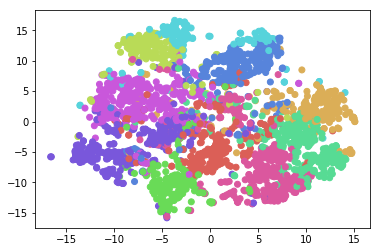

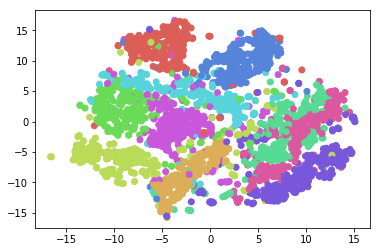

-------------------------------------
  k = 100  
-------------------------------------

0 | Mayority: 1
-------------------------------------
Size: mayority 154 | full: 317
Percentage of majority class: 48.580441640378545 % 


1 | Mayority: 9
-------------------------------------
Size: mayority 92 | full: 242
Percentage of majority class: 38.01652892561984 % 


2 | Mayority: 0
-------------------------------------
Size: mayority 167 | full: 189
Percentage of majority class: 88.35978835978835 % 


3 | Mayority: 1
-------------------------------------
Size: mayority 180 | full: 255
Percentage of majority class: 70.58823529411765 % 


4 | Mayority: 7
-------------------------------------
Size: mayority 132 | full: 338
Percentage of majority class: 39.053254437869825 % 


5 | Mayority: 0
-------------------------------------
Size: mayority 110 | full: 149
Percentage of majority class: 73.8255033557047 % 


6 | Mayority: 6
-------------------------------------
Size: mayority 267 | full: 32

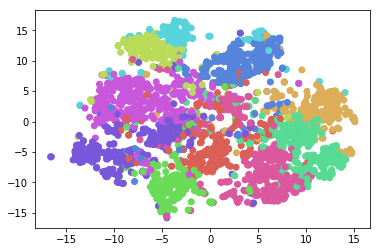

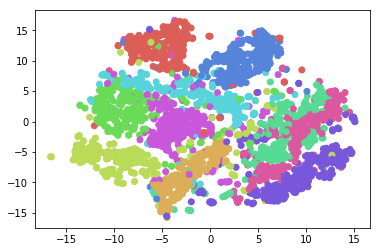

-------------------------------------
  k = 1000  
-------------------------------------

0 | Mayority: 1
-------------------------------------
Size: mayority 154 | full: 317
Percentage of majority class: 48.580441640378545 % 


1 | Mayority: 9
-------------------------------------
Size: mayority 92 | full: 242
Percentage of majority class: 38.01652892561984 % 


2 | Mayority: 0
-------------------------------------
Size: mayority 167 | full: 189
Percentage of majority class: 88.35978835978835 % 


3 | Mayority: 1
-------------------------------------
Size: mayority 180 | full: 255
Percentage of majority class: 70.58823529411765 % 


4 | Mayority: 7
-------------------------------------
Size: mayority 132 | full: 338
Percentage of majority class: 39.053254437869825 % 


5 | Mayority: 0
-------------------------------------
Size: mayority 110 | full: 149
Percentage of majority class: 73.8255033557047 % 


6 | Mayority: 6
-------------------------------------
Size: mayority 267 | full: 3

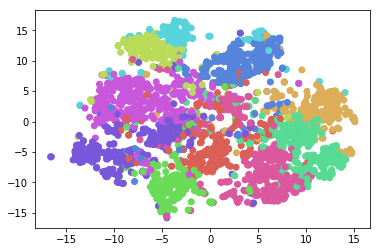

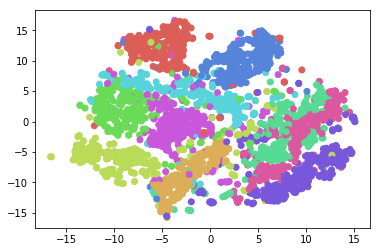

In [14]:
print("-------------------------------------")
print("  k = 10  ")
print("-------------------------------------")
kmeans_train(10, mnist_kmeans["x_train"], mnist_kmeans["y_train"])

print("-------------------------------------")
print("  k = 100  ")
print("-------------------------------------")
kmeans_train(90, mnist_kmeans["x_train"], mnist_kmeans["y_train"])

print("-------------------------------------")
print("  k = 1000  ")
print("-------------------------------------")
mnist_kmeans_wrong_predictions = kmeans_train(900, mnist_kmeans["x_train"], mnist_kmeans["y_train"])

### Oberer Plot: Cluster nach Cluster Nummer (nicht majortiy class) 
### Unterer Plot: Tatsächliche Zahlen
## Legende
* 0: Rot
* 1: Gold
* 2: Neongelb
* 3: Hellgrün
* 4: Türkis
* 5: Hellblau
* 6: Blau
* 7: Sehr Dunkel Lila
* 8: Lila
* 9: Hell Lila (ähnlich zu rot)



### Do this for 10, 100, 1000 iterations:

<h3>What is the majority class of each cluster? <br>What is the percentage of the majority class in each cluster? </h3>
<p> Siehe Ergebnis der oberen Zelle </p>

### Does each number have a cluster?
<p> Nein.</p>

### If not, which hasn’t?

<p> Siehe Ergebnis der oberen Zelle (not represented) </p>

## D MNIST understanding

##### Some numbers are more difficult to predict with KNN and to cluster with K-means. Show why.  Start with examples, and get more general

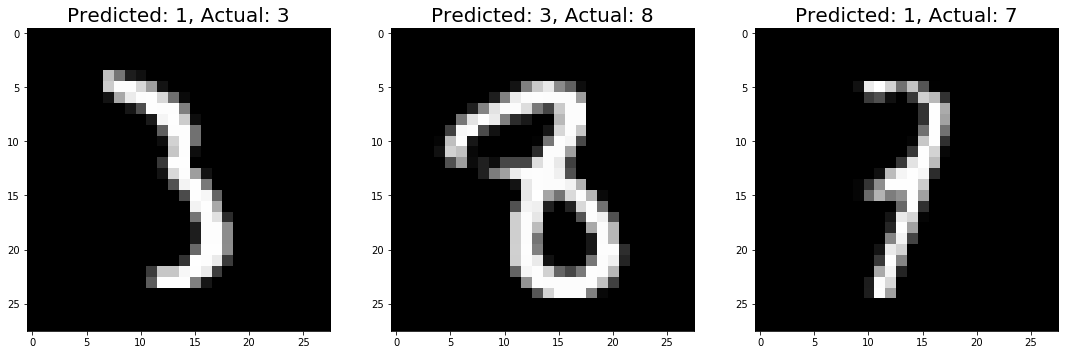

In [15]:
if mnist_knn_wrong_predictions.shape[0] >= 1:
    show_wrong_predictions(mnist_knn_wrong_predictions, mnist_knn["x_test"], 11, False)
else:
    print("No wrong predictions")

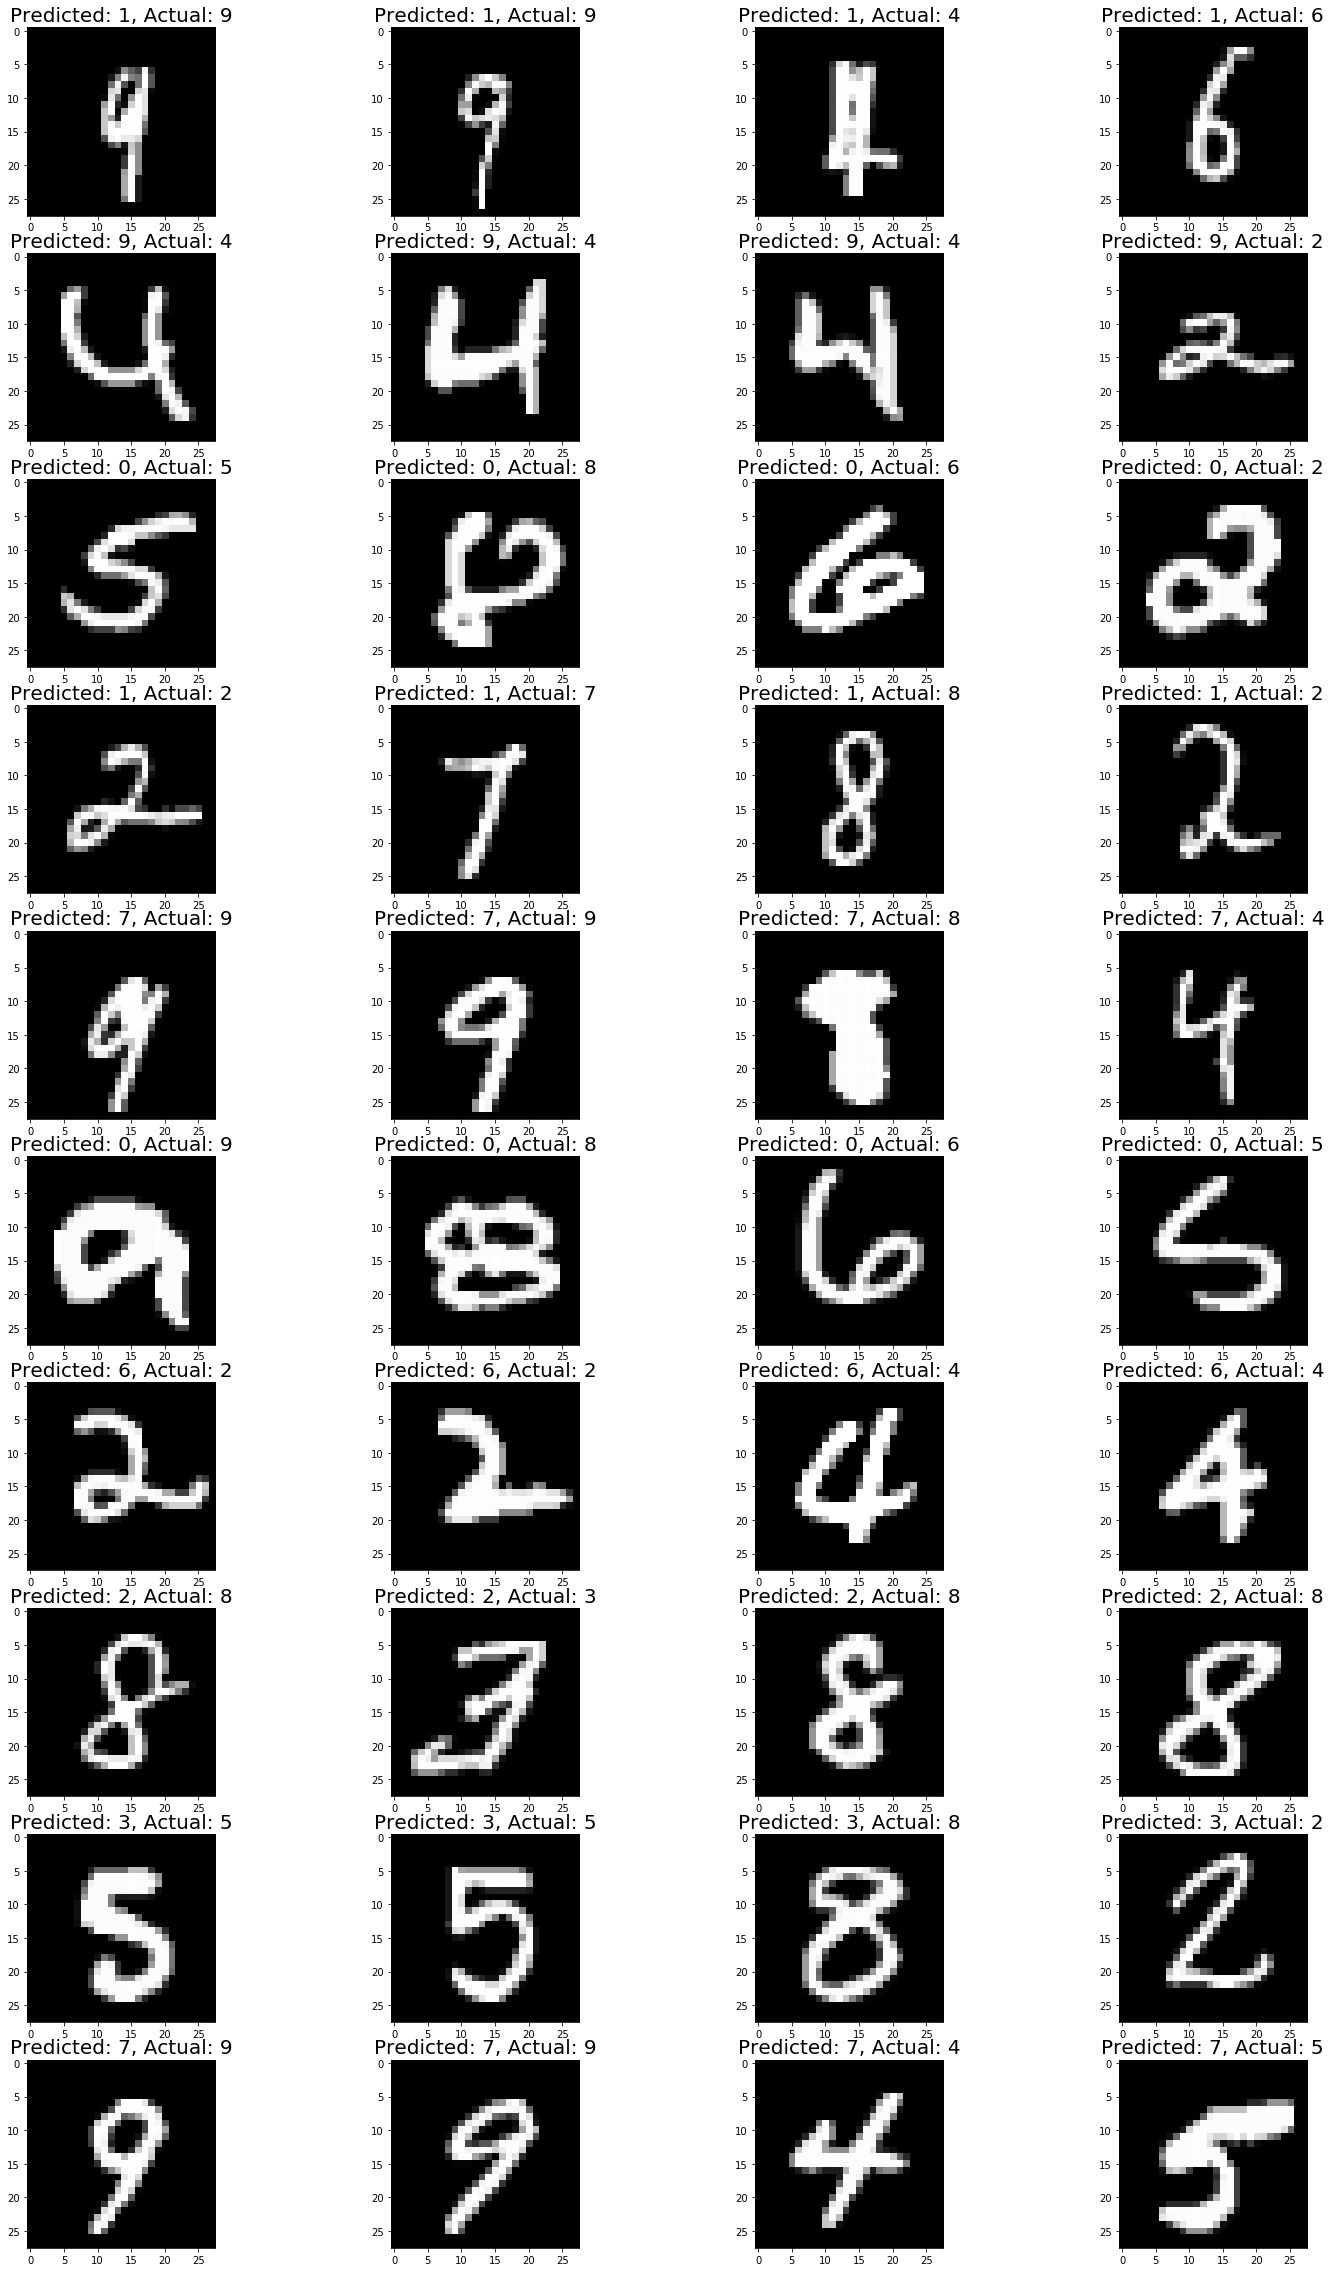

In [16]:
if mnist_kmeans_wrong_predictions.shape[0] >= 1:
    show_wrong_predictions(mnist_kmeans_wrong_predictions, mnist_kmeans["x_train"],45, False)
else:
    print("No wrong predictions")

### Fazit:
<p>Schauen wir uns nun die Sammlung der falsch eingeordneten Zahlen an, so sehen wir, dass viele Pixel mit denen, der geratenen Zahlen überein stimmen. Sie ähneln mehr den geratenen Zahlen als den richtigen. Mit ähneln ist gemeint, dass mehr Pixel "übereinstimmen"(Schnittmenge der weißen Pixel). Knn erkennt nämlich nicht, wo die Pixel sich im Bild befinden, bzw. erkennt nicht die Zusammenhänge zwischen den Positionen der Pixel, sondern nur deren Werte (Da jeder Pixel den Wert für eine Dimension bie der Distanzberechnung bestimmt ist jede "Pixel-Achse" von jeder "gleiwchweit entfernt" wodurch der Context in dem die Pixel zueinander stehen verloren geht)</p>

<p> Bei k-means werden diese falschzuordnung noch weiter verstärkt, da die Zahlen, die fälschlicherweiße eingeordnet werden, zur Neuzuordnung in der nächsten Itteration als Vergelcihsdaten beitragen.</p>
<p>Bsp. in der ersten Itteration werden viele 5er und einige 8er in einen einzigen cluster gepackt, was dazu führt, dass der neue Zentroid vermutlich eine 8 wird, die viele Ähnlichkeiten mit einer 5 aufweißt. Bei der nächsten Itteration werden dadurch dann noch alle anderen Ziffern, die ähnlich aussehen wie 5er und 8er hinzugefügt.</p>
<p> Da k-means die Labels der Ziffern nicht kennt, geht es dann davon aus, dass es nicht die Ziffern 5 und 8 gibt, sondern eine Ziffer die so aussieht wie die Mischung aus beiden</p>

## E KNN and K-means CIFAR

### transform cifar-10 to grayscale.
Siehe oben beim Laden von CIFAR

## Demonstrate this similar to B, C and D

## E.B KNN

In [17]:
cifar_knn = get_cifar_subsets(10000,50)

In [18]:
predictions2 = knn(2, cifar_knn["x_train"], cifar_knn["y_train"], cifar_knn["x_test"])
predictions4 = knn(4, cifar_knn["x_train"], cifar_knn["y_train"], cifar_knn["x_test"])
predictions8 = knn(8, cifar_knn["x_train"], cifar_knn["y_train"], cifar_knn["x_test"])

print(list(y_cifar_test), "\n")

print("-------------------------------------")
print("  2NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions2, "\n")
knn_print_error_rate(y_cifar_test, predictions2)

print("-------------------------------------")
print("  4NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions4, "\n")
knn_print_error_rate(y_cifar_test, predictions4)

print("-------------------------------------")
print("  8NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions8, "\n")
cifar_knn_wrong_predictions = knn_print_error_rate(y_cifar_test,predictions8)


[3, 7, 5, 3, 0, 9, 6, 5, 0, 9, 2, 6, 2, 8, 5, 3, 4, 7, 8, 6, 4, 3, 1, 7, 8, 0, 0, 8, 6, 6, 7, 4, 7, 2, 1, 2, 6, 3, 6, 7, 9, 0, 0, 3, 6, 1, 2, 2, 8, 6] 

-------------------------------------
  2NN  
-------------------------------------
Predictions:
[3, 4, 5, 2, 8, 7, 2, 0, 2, 8, 2, 6, 4, 5, 0, 2, 2, 5, 8, 4, 0, 6, 1, 2, 0, 0, 0, 8, 6, 4, 2, 3, 6, 2, 1, 2, 0, 8, 4, 4, 3, 0, 0, 3, 0, 6, 0, 6, 0, 4] 

Label: 0
   4 out of 6 recognized correctly | Errorrate: 33.333333333333336 %
Label: 1
   2 out of 3 recognized correctly | Errorrate: 33.333333333333336 %
Label: 2
   3 out of 6 recognized correctly | Errorrate: 50.0 %
Label: 3
   2 out of 6 recognized correctly | Errorrate: 66.66666666666667 %
Label: 4
   0 out of 3 recognized correctly | Errorrate: 100.0 %
Label: 5
   1 out of 3 recognized correctly | Errorrate: 66.66666666666667 %
Label: 6
   2 out of 9 recognized correctly | Errorrate: 77.77777777777779 %
Label: 7
   0 out of 6 recognized correctly | Errorrate: 100.0 %
Label: 8
   2 ou

### What is the error rate of KNN on the test set?
Siehe Ergebnis der oberen Zelle

### What is the error rate for each label (number)?
Siehe Ergebnis der oberen Zelle

### How does the choice of k influence the result?

Beim Testen mit anderen Subsets ist aufgefallen, dass k sich nicht stark auf die Errorquote auswirkt, aber k=2 und k=4 tendenziell niedrigere Errorraten für unsere Test- und Traingrößen hatte.

### Does knn work similarly good for cifar?
<p>Nein. Obwohl manche Trainingssets mit einer Errorate von weniger als 70% ca. 20% besser waren als zufälliges raten, ist das nicht mit den weniger als 10% bzw. häufig auch weniger als 5% Errorraten unserer knn Testreihen zu vergleichen. Grund dafür ist, dass Bilder von den gleichen Dingen im gegensatz zu Bildern von den gleichen Ziffern nicht ähnlich aussehen.</p>
<p>Bsp.: Ein stark überbelichtetes Bild und ein stark unterbelichtetes Bild von einem Hund haben sehr unterschiedliche Werte für ihre Graustufen pixel (hellgrau / schwarz). Während ein überbelichtetes Bild von einem Hund und ein überbelichtetes Bild von einem Lkw sehr ähnliche Werte für die einzelnen Pixel haben (hellgrau/hellgrau)</p>
<p>Außerdem sorgen noch andere Faktoren, wie zum Beispiel verschiedene Blickwinkel und "Zuschnitte" dafür, dass selbst bei gleicher Beleuchtung, sich Bilder von den gleichen Objekten nicht ähnlich sehen (auf einer Pixel für Pixel Basis)</p>

## E.C K-means CIFAR

In [19]:
cifar_kmeans = get_cifar_subsets(3000,0)
k_cifar = 10
kmeans_start(cifar_kmeans["x_train"], k_cifar)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.344s...
[t-SNE] Computed neighbors for 3000 samples in 36.586s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 421.645345
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.270073
[t-SNE] KL divergence after 300 iterations: 2.416133


-------------------------------------
  k = 10  
-------------------------------------

0 | Mayority: 8
-------------------------------------
Size: mayority 82 | full: 242
Percentage of majority class: 33.88429752066116 % 


1 | Mayority: 9
-------------------------------------
Size: mayority 49 | full: 191
Percentage of majority class: 25.654450261780106 % 


2 | Mayority: 6
-------------------------------------
Size: mayority 73 | full: 349
Percentage of majority class: 20.916905444126073 % 


3 | Mayority: 7
-------------------------------------
Size: mayority 58 | full: 271
Percentage of majority class: 21.40221402214022 % 


4 | Mayority: 4
-------------------------------------
Size: mayority 57 | full: 288
Percentage of majority class: 19.791666666666664 % 


5 | Mayority: 9
-------------------------------------
Size: mayority 87 | full: 251
Percentage of majority class: 34.66135458167331 % 


6 | Mayority: 7
-------------------------------------
Size: mayority 54 | full: 291
Per

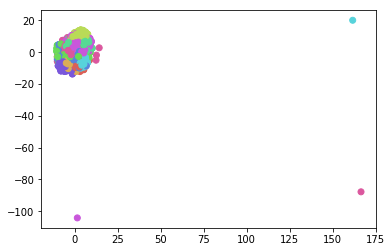

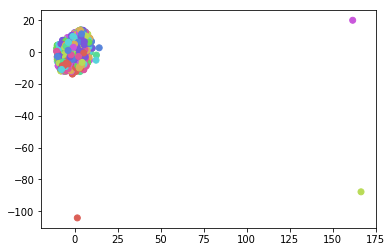

-------------------------------------
  k = 100  
-------------------------------------

0 | Mayority: 8
-------------------------------------
Size: mayority 90 | full: 256
Percentage of majority class: 35.15625 % 


1 | Mayority: 9
-------------------------------------
Size: mayority 47 | full: 204
Percentage of majority class: 23.03921568627451 % 


2 | Mayority: 6
-------------------------------------
Size: mayority 70 | full: 329
Percentage of majority class: 21.27659574468085 % 


3 | Mayority: 7
-------------------------------------
Size: mayority 47 | full: 222
Percentage of majority class: 21.17117117117117 % 


4 | Mayority: 4
-------------------------------------
Size: mayority 58 | full: 331
Percentage of majority class: 17.522658610271904 % 


5 | Mayority: 9
-------------------------------------
Size: mayority 88 | full: 247
Percentage of majority class: 35.62753036437247 % 


6 | Mayority: 7
-------------------------------------
Size: mayority 77 | full: 400
Percentage of

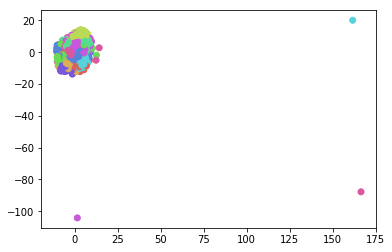

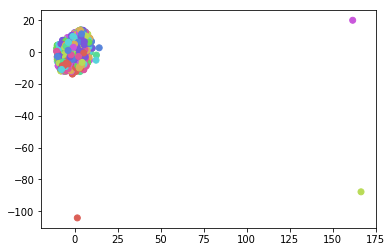

-------------------------------------
  k = 1000  
-------------------------------------

0 | Mayority: 8
-------------------------------------
Size: mayority 90 | full: 256
Percentage of majority class: 35.15625 % 


1 | Mayority: 9
-------------------------------------
Size: mayority 47 | full: 204
Percentage of majority class: 23.03921568627451 % 


2 | Mayority: 6
-------------------------------------
Size: mayority 70 | full: 329
Percentage of majority class: 21.27659574468085 % 


3 | Mayority: 7
-------------------------------------
Size: mayority 47 | full: 222
Percentage of majority class: 21.17117117117117 % 


4 | Mayority: 4
-------------------------------------
Size: mayority 58 | full: 331
Percentage of majority class: 17.522658610271904 % 


5 | Mayority: 9
-------------------------------------
Size: mayority 88 | full: 247
Percentage of majority class: 35.62753036437247 % 


6 | Mayority: 7
-------------------------------------
Size: mayority 77 | full: 400
Percentage o

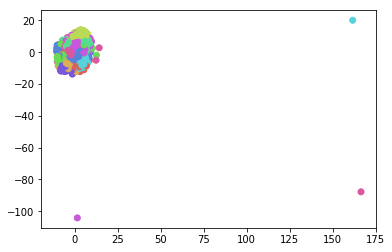

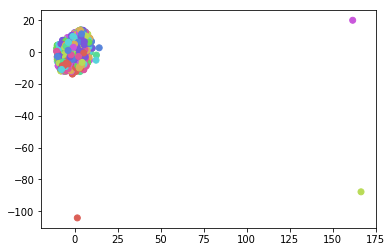

In [20]:
print("-------------------------------------")
print("  k = 10  ")
print("-------------------------------------")
kmeans_train(10, cifar_kmeans["x_train"] ,cifar_kmeans["y_train"])

print("-------------------------------------")
print("  k = 100  ")
print("-------------------------------------")
kmeans_train(90, cifar_kmeans["x_train"] ,cifar_kmeans["y_train"])

print("-------------------------------------")
print("  k = 1000  ")
print("-------------------------------------")
cifar_kmeans_wrong_predictions = kmeans_train(900, cifar_kmeans["x_train"] ,cifar_kmeans["y_train"])

### Do this for 10, 100, 1000 iterations:

<h3>What is the majority class of each cluster? <br>What is the percentage of the majority class in each cluster? </h3>
<p> Siehe Ergebnis der oberen Zelle </p>

### Does each number have a cluster?
<p> Nein.</p>

### If not, which hasn’t?

<p> Siehe Ergebnis der oberen Zelle (not represented) </p>

### Does k-means work similarly good for cifar?

<p>Nein. CIFAR hat mayority-classes im Bereich von 10-40% während MNIST Bereiche von 40-95% hat. Betrachtet man das Diagramm der korrekten CIFAR Daten, kann man kein Muster innerhalb des Datensatzes erkennen. Alle Punkte sind viel enger zusammen und miteinander vermischt und nicht in Clustern von gleichen Labels geordnet. Dies wird besonders deutlich, wenn man es mit dem Diagramm des MNIST-Datensatzes vergleicht</p>

## E.D CIFAR understanding

##### Some numbers are more difficult to predict with KNN and to cluster with K-means. Show why.  Start with examples, and get more general

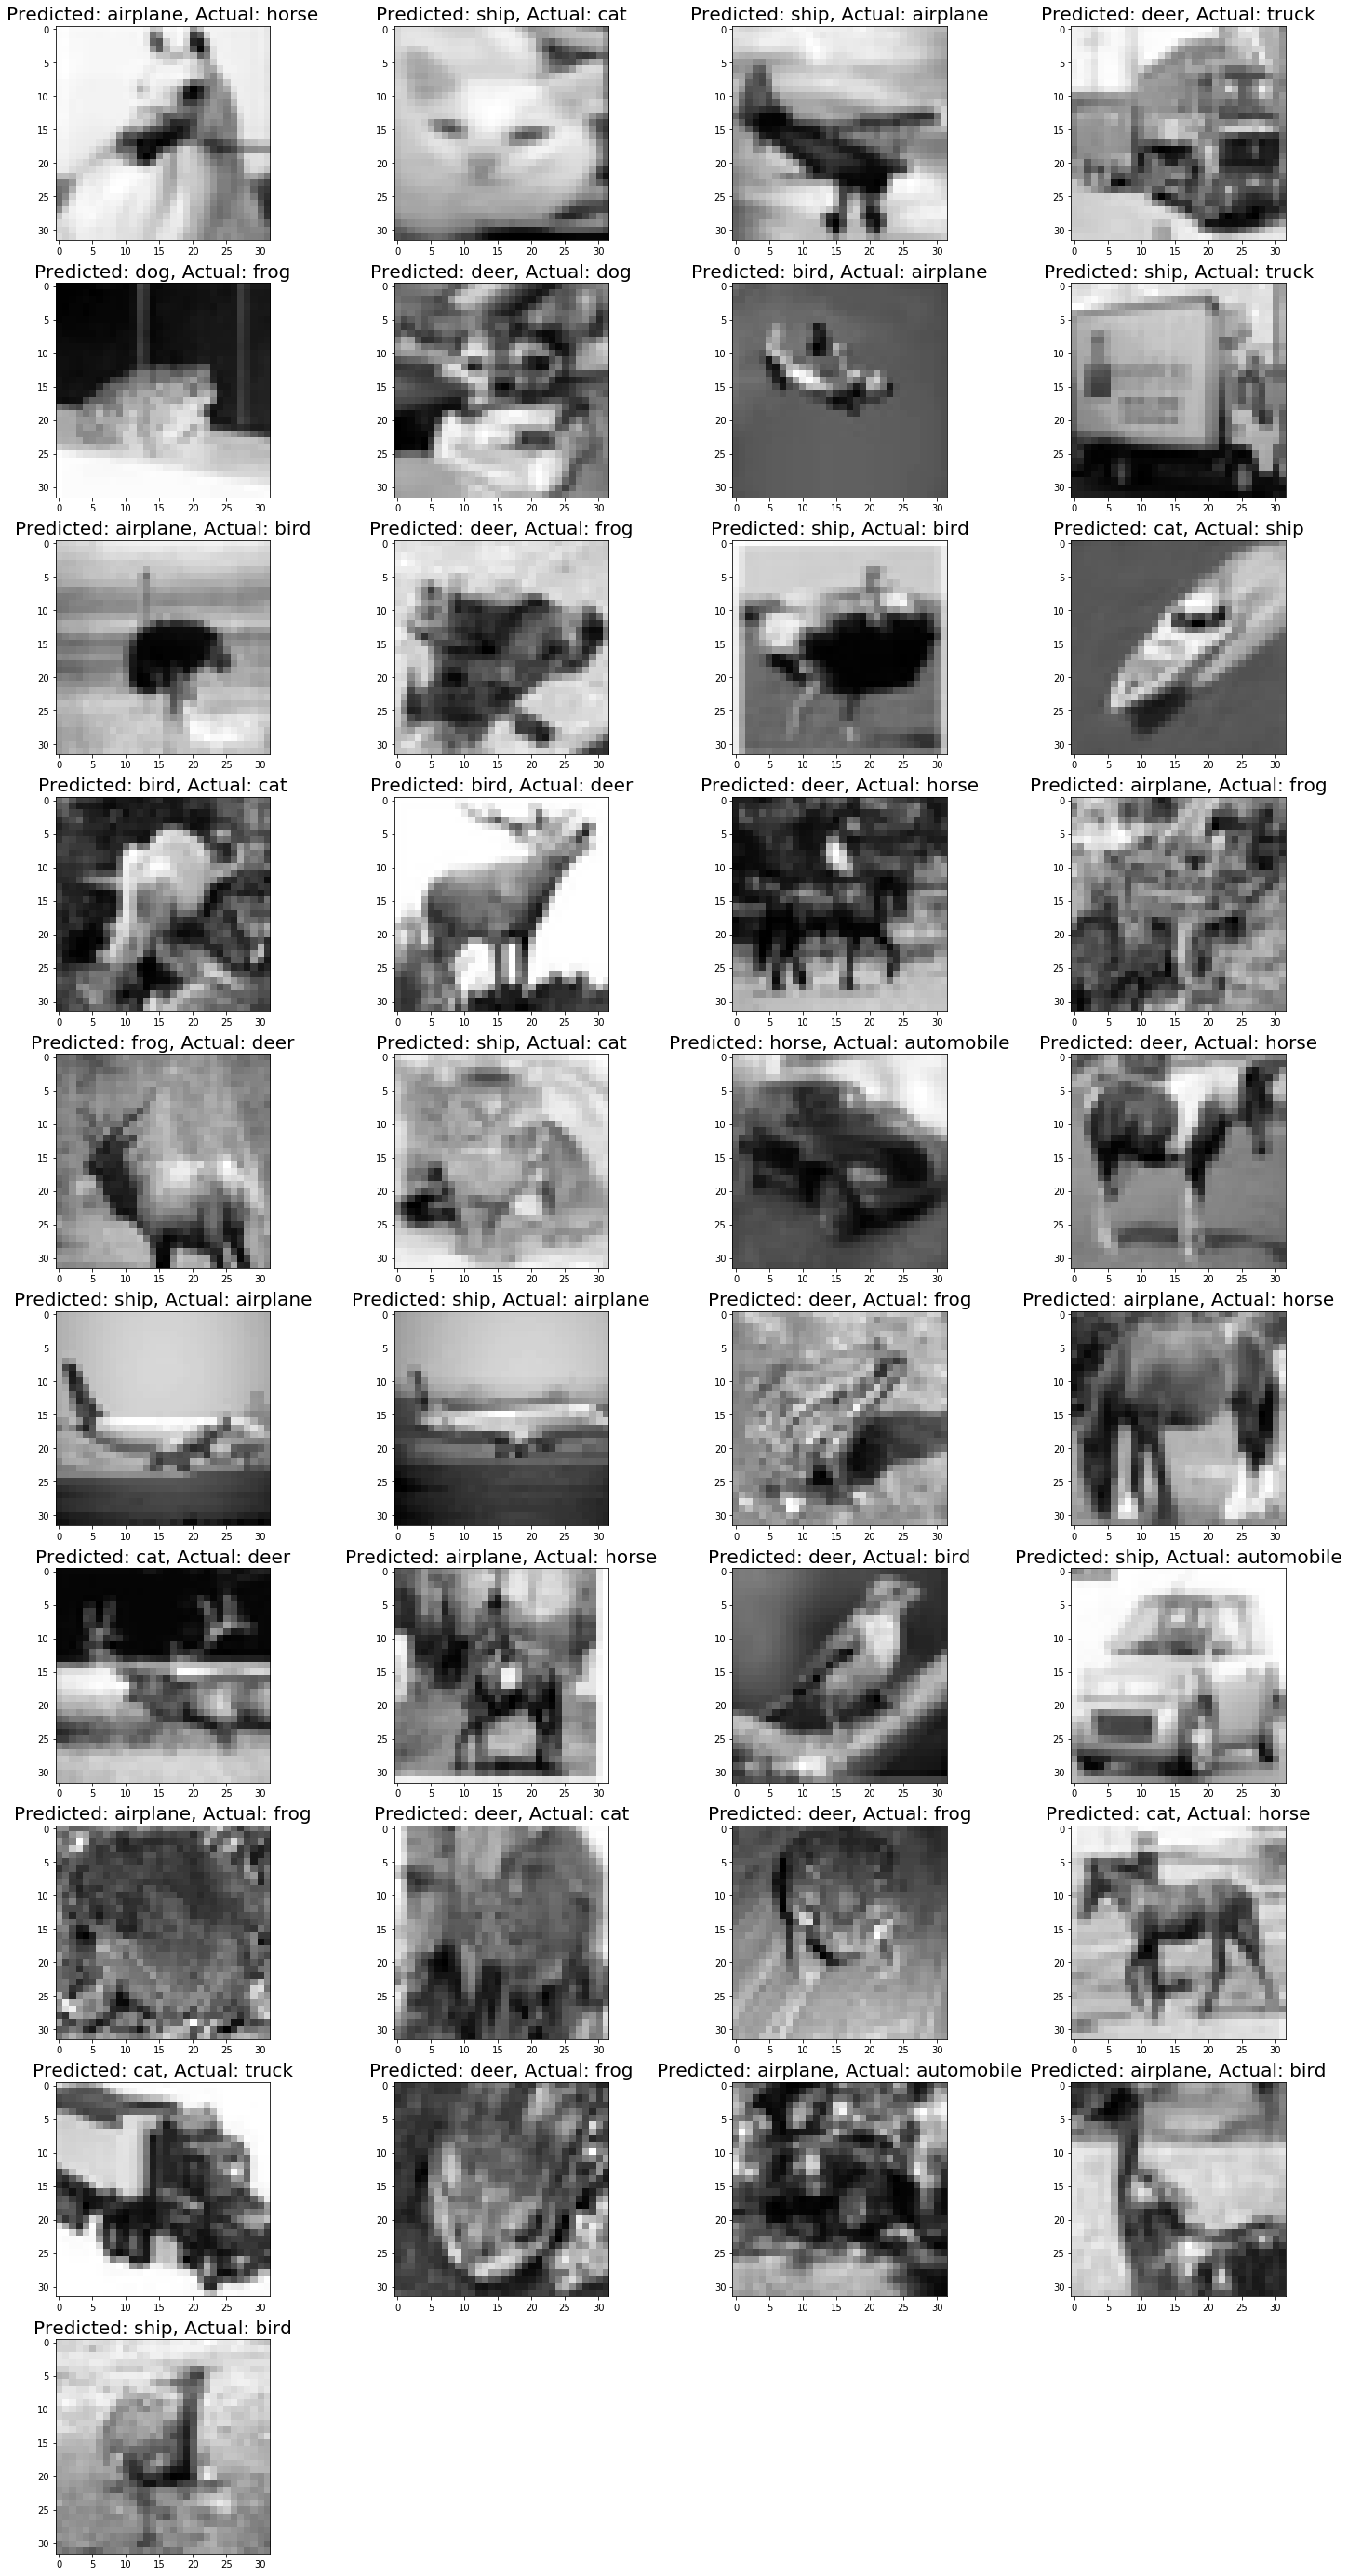

In [21]:
if cifar_knn_wrong_predictions.shape[0] >= 1:
    show_wrong_predictions(cifar_knn_wrong_predictions, cifar_knn["x_test"], 50, True)
else:
    print("No wrong predictions")

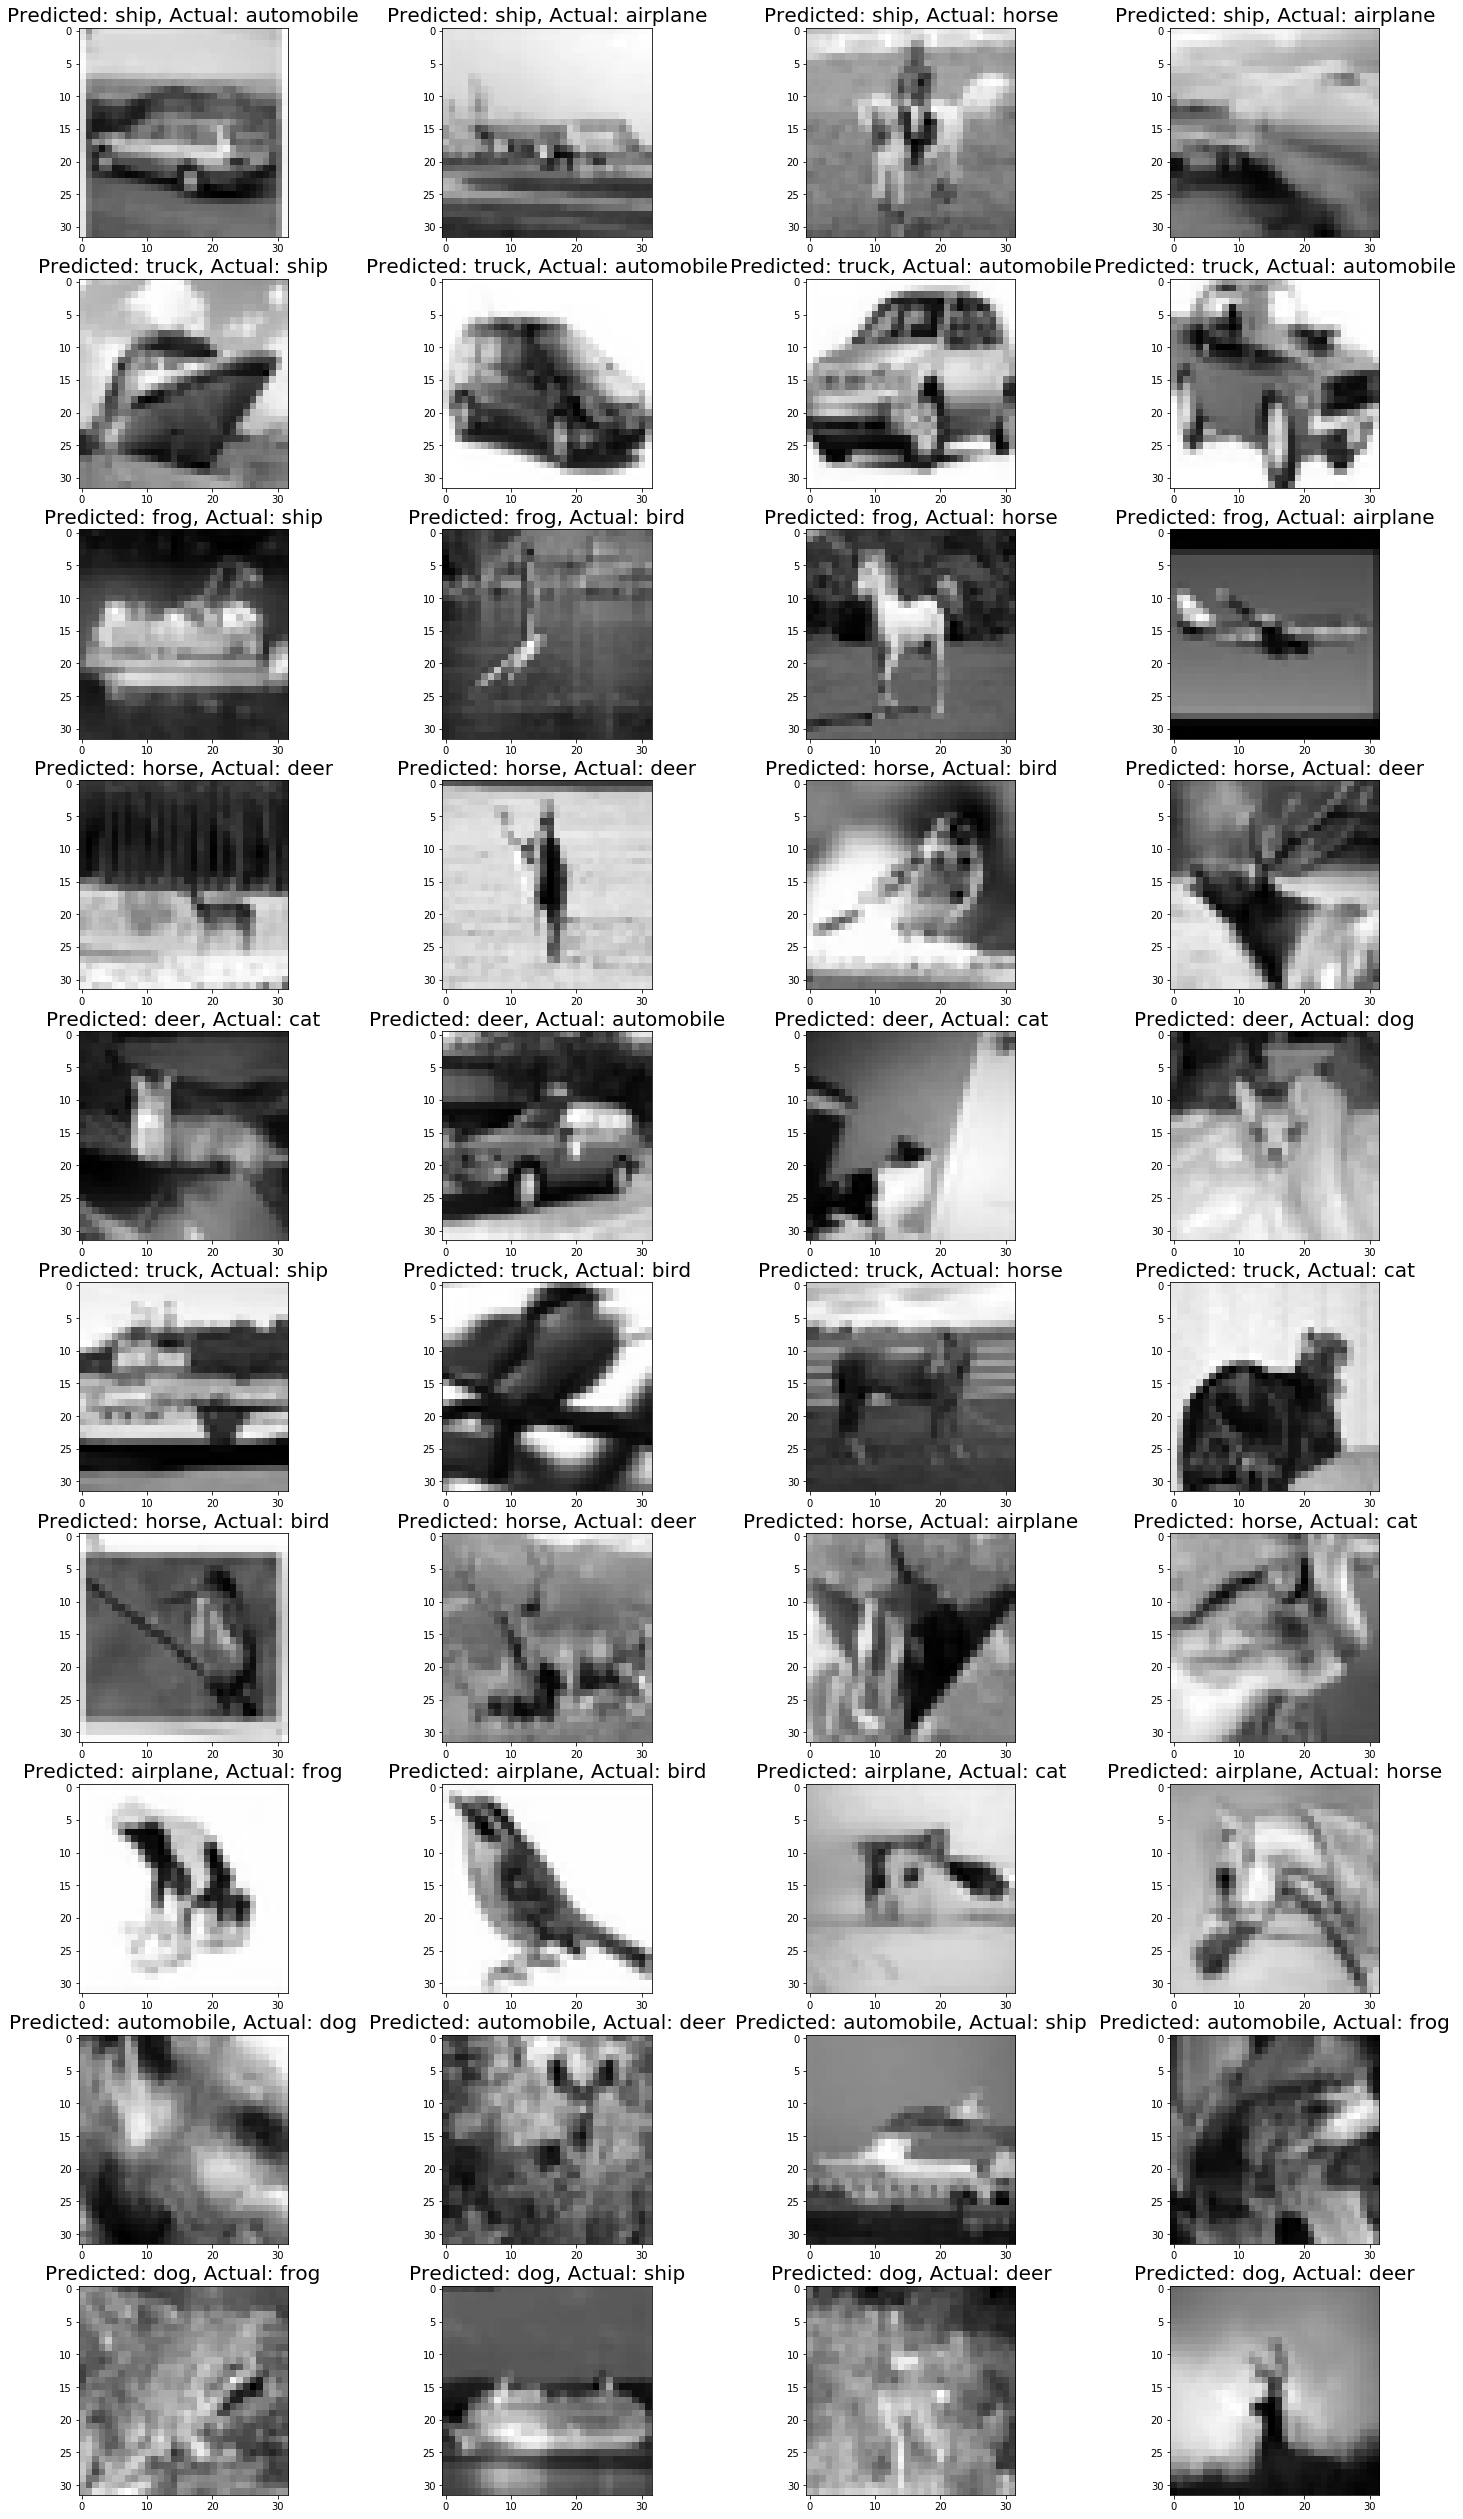

In [22]:
if cifar_kmeans_wrong_predictions.shape[0] >= 1:
    show_wrong_predictions(cifar_kmeans_wrong_predictions, cifar_kmeans["x_train"], 50, True)
else:
    print("No wrong predictions")

### Fazit
CIFAR ist weder für knn noch für k-means wirklich geeignet, da die Schnittmengen der Graustufen-Pixelmaps der Bilder innerhalb einer Klasse nicht wirklich ähnlicher sind als die zwischen den Klassen.

## F Linear regression BOSTON

Train a linear regression model on the BOSTON dataset to predict median
values of houses. Test it on the test set. Show the code how you did it! What
dependent variables (columns) have the biggest influence?

 RM and lstat have the biggest influence 


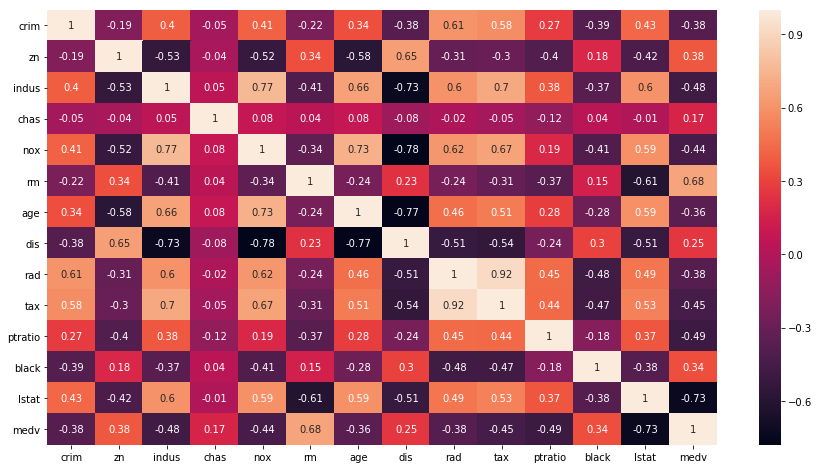

In [23]:
plt.rcParams['figure.figsize'] = [15, 8]

np.set_printoptions(suppress=True)

boston = tf.keras.datasets.boston_housing.load_data()[0]
X = boston[0]
Y = boston[1]


c = ["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat", 'medv']
boston = pd.DataFrame({c: X[:, i] for i, c in enumerate(c[:-1])})
boston[c[-1]] = Y
#add median 
np.median(boston)

boston.head()

#Correlation Matrix
correlation_matrix = boston.corr().round(2)

sns.heatmap(data= correlation_matrix, annot=True)

print(" RM and lstat have the biggest influence ")

###Select target variable 

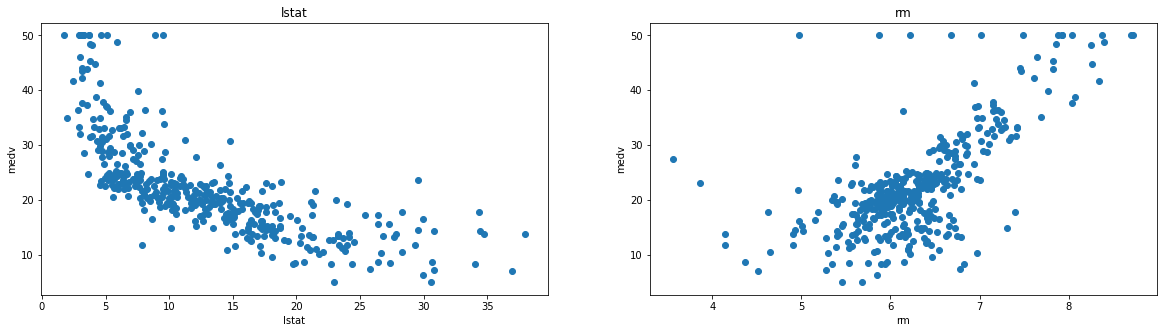

In [24]:
plt.figure(figsize=(20, 5))

features = ['lstat', 'rm']
target = boston['medv']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('medv')

## G Logistik regression MNIST

Evalute logistic regression as B and D on MNIST

## H Feedback

How much time did you work on this assignment and how often did you
meet?
* Did you use Google Colab or Anaconda?
* What was your favourite excercise? Why?
* What excercise did you like least? Why?